In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image

## Mapping Dataset

In [4]:
# Selecting Dataset Folder Paths
f_dir_ = Path('../input/eyes-rtte/femaleeyes')
m_dir_ = Path('../input/eyes-rtte/maleeyes')
femaleeyes_filepaths = list(f_dir_.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir_.glob(r'**/*.jpg'))

# Mapping the labels
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))

# Paths & labels femalee eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Paths & labels malee eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Concatenating...
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)

df = pd.concat([femaleeyes_df, maleeyes_df])

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

In [5]:
plt.style.use("seaborn-white")

/tmp/ipykernel_32/3081854136.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


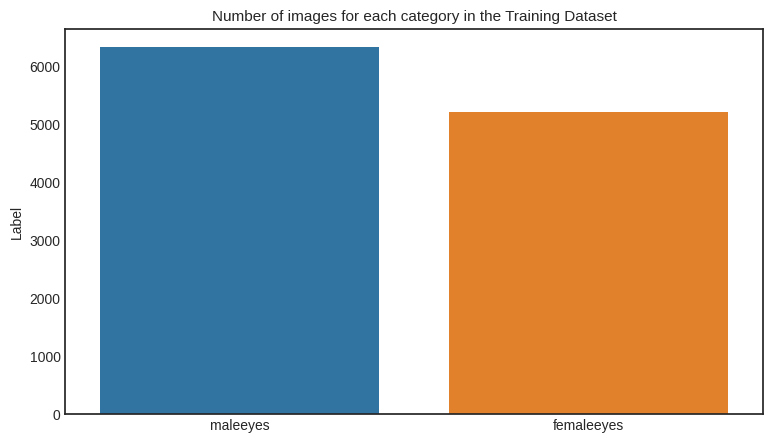

In [6]:
vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

## Observing Dataset

Text(0.5, 1.0, 'maleeyes')

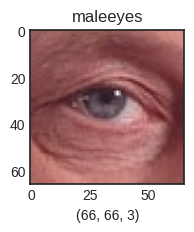

In [7]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][50])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][50])

Text(0.5, 1.0, 'femaleeyes')

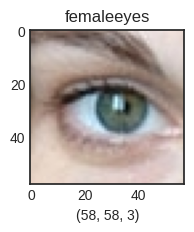

In [8]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][11])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][11])

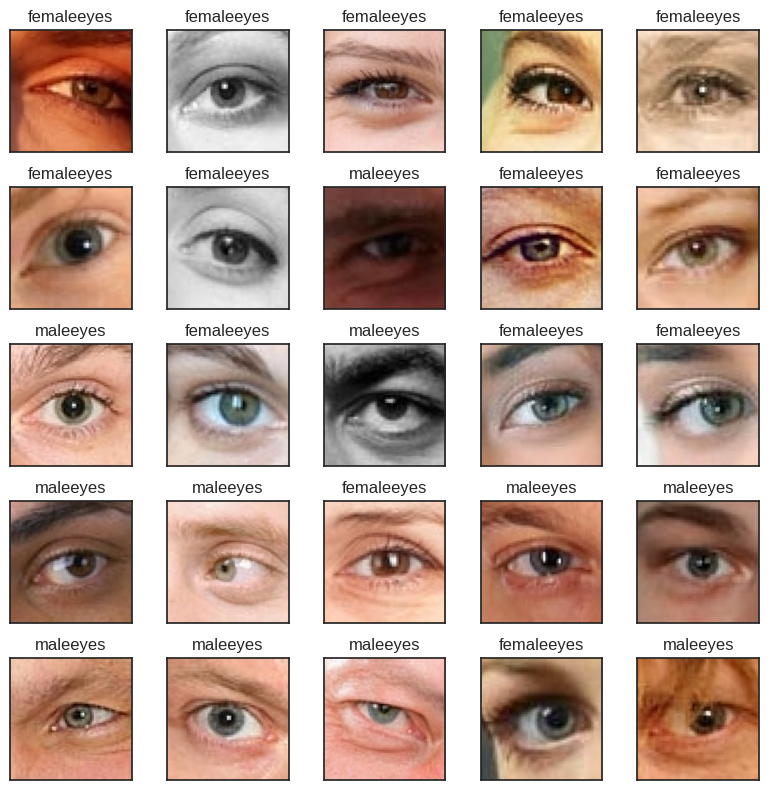

In [9]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (8, 8),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

## Split Dataset

In [10]:
trainset_df, testset_df = train_test_split(df, train_size = 0.75, random_state = 4)

display(trainset_df.head())

testset_df.head()

,File,Label
5614,../input/eyes-rtte/maleeyes/7262.jpg,maleeyes
862,../input/eyes-rtte/femaleeyes/3775.jpg,femaleeyes
9030,../input/eyes-rtte/femaleeyes/128.jpg,femaleeyes
7482,../input/eyes-rtte/maleeyes/889.jpg,maleeyes
5000,../input/eyes-rtte/maleeyes/3309.jpg,maleeyes


,File,Label
3814,../input/eyes-rtte/femaleeyes/6254.jpg,femaleeyes
5238,../input/eyes-rtte/femaleeyes/5784.jpg,femaleeyes
2768,../input/eyes-rtte/femaleeyes/6847.jpg,femaleeyes
2398,../input/eyes-rtte/maleeyes/4254.jpg,maleeyes
9093,../input/eyes-rtte/maleeyes/306.jpg,maleeyes


In [11]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [12]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with malee eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with malee eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with femalee eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 8643
Number of images with malee eyes: 4729
Number of images with femalee eyes: 3914

Test Dataset:
Number of images: 2882
Number of images with malee eyes: 1594
Number of images with femalee eyes: 1288



## Generate Batch Images & Preparing Dataset

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [14]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 7779 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 864 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 2882 validated image filenames belonging to 2 classes.
Data generators are ready!


In [15]:
print("Training: ")
print(training_set.class_indices)
print(training_set.image_shape)
print("---" * 8)
print("Validation: ")
print(validation_set.class_indices)
print(validation_set.image_shape)
print("---" * 8)
print("Test: ")
print(test_set.class_indices)
print(test_set.image_shape)

Training: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Validation: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Test: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)


In [16]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 15, restore_best_weights = True)]

## Setup CNN Model

### 1-Convolution

In [17]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (75, 75, 3), activation = 'relu'))
CNN.add(BatchNormalization())

### 2-Max Pooling

In [18]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))

### 3-Hidden Layers

In [19]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

### 4-Flattening

In [20]:
CNN.add(Flatten())

### 5-Dense Neural Network

In [21]:
# Input layer
CNN.add(Dense(units = 128, activation = 'relu'))
CNN.add(Dropout(0.2))
# Output layer (binary classification)
CNN.add(Dense(units = 1, activation = 'sigmoid'))

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                        

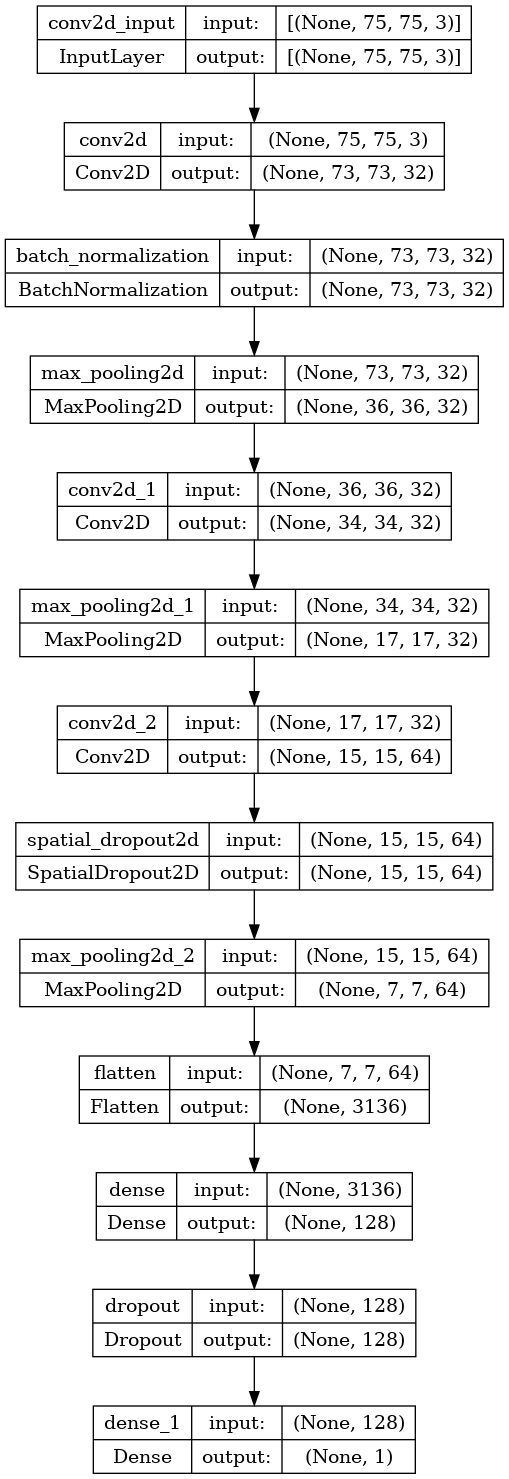

In [22]:
plot_model(CNN, to_file='CNN_model.png', show_layer_names = True , show_shapes = True)

### 6-Model Compilation & Training

In [23]:
# Compile
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time...
start = dt.datetime.now()

# Train
CNN_model = CNN.fit(training_set, epochs = 10, validation_data = validation_set, callbacks = cb)

# End of counting time...
end = dt.datetime.now()
time_CNN = end - start
print ('\nTraining and validation time is: ', time_CNN)

Epoch 1/10
244/244 [==============================] - 91s 363ms/step - loss: 0.6263 - accuracy: 0.6510 - val_loss: 0.6314 - val_accuracy: 0.7176
Epoch 2/10
244/244 [==============================] - 52s 211ms/step - loss: 0.5292 - accuracy: 0.7365 - val_loss: 0.5510 - val_accuracy: 0.7292
Epoch 3/10
244/244 [==============================] - 51s 211ms/step - loss: 0.4719 - accuracy: 0.7766 - val_loss: 0.4838 - val_accuracy: 0.7720
Epoch 4/10
244/244 [==============================] - 50s 205ms/step - loss: 0.4190 - accuracy: 0.8023 - val_loss: 0.3858 - val_accuracy: 0.8264
Epoch 5/10
244/244 [==============================] - 50s 206ms/step - loss: 0.3836 - accuracy: 0.8333 - val_loss: 0.3527 - val_accuracy: 0.8553
Epoch 6/10
244/244 [==============================] - 50s 204ms/step - loss: 0.3571 - accuracy: 0.8472 - val_loss: 0.3674 - val_accuracy: 0.8449
Epoch 7/10
244/244 [==============================] - 50s 205ms/step - loss: 0.3454 - accuracy: 0.8474 - val_loss: 0.3492 - val_ac

### 7-Model Training Report

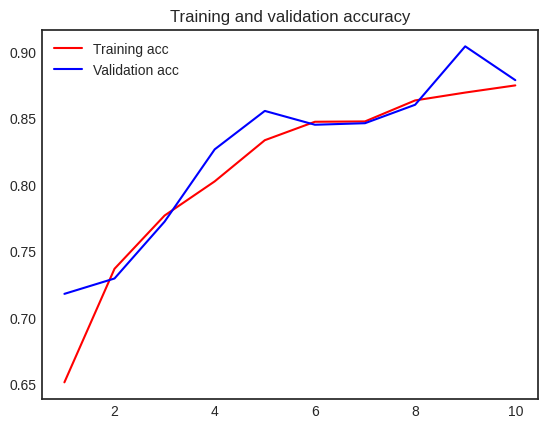

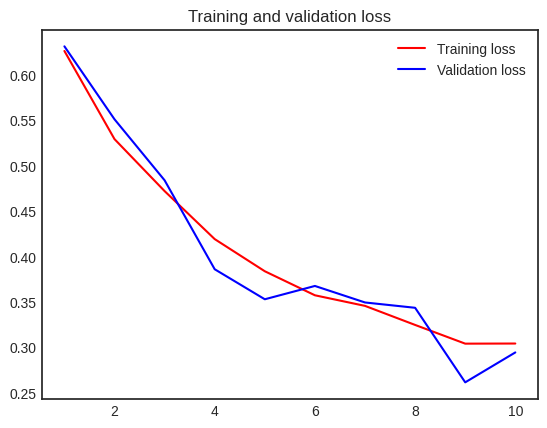

In [24]:
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()
plt.show()


In [25]:
score_CNN = CNN.evaluate(test_set)
print("Test Loss:", score_CNN[0])
print("Test Accuracy:", score_CNN[1])

91/91 [==============================] - 22s 244ms/step - loss: 0.2290 - accuracy: 0.9063
Test Loss: 0.22904428839683533
Test Accuracy: 0.9063150882720947


In [26]:
y_pred_CNN = CNN.predict(test_set)
y_pred_CNN = np.round(y_pred_CNN)

recall_CNN = recall_score(y_test, y_pred_CNN)
precision_CNN = precision_score(y_test, y_pred_CNN)
f1_CNN = f1_score(y_test, y_pred_CNN)
roc_CNN = roc_auc_score(y_test, y_pred_CNN)

91/91 [==============================] - 5s 58ms/step


### 8-Classification Report

In [27]:
print(classification_report(y_test, y_pred_CNN))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89      1288
           1       0.89      0.95      0.92      1594

    accuracy                           0.91      2882
   macro avg       0.91      0.90      0.90      2882
weighted avg       0.91      0.91      0.91      2882



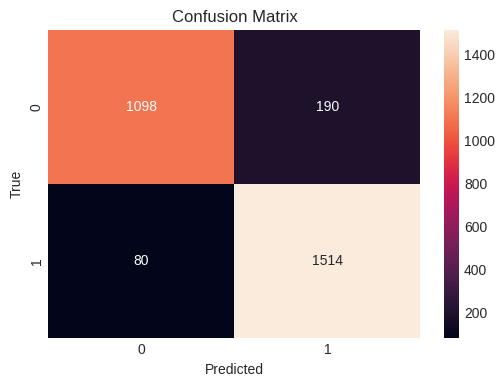

In [28]:
plt.figure(figsize = (6, 4))

sns.heatmap(confusion_matrix(y_test, y_pred_CNN),annot = True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [29]:
# Save the model
modelFileName = 'eye-classifier.h5'
CNN.save(modelFileName)
print('model saved as', modelFileName)

model saved as eye-classifier.h5


In [6]:
# Menguji coba model
import numpy as np
from keras.preprocessing import image


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing 
#atau kalian langsung import file gambarnya langsung
uploaded = '/kaggle/input/eyes-rtte/femaleeyes/1.jpg'
 
for fn in uploaded.keys():
 
  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)
  
  print(fn)
  if classes==0:
    print('Male')
  elif classes==1:
    print('Female')
 

AttributeError: 'str' object has no attribute 'keys'